In [2]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

from scipy.signal import ShortTimeFFT
from scipy.signal.windows import gaussian

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts

#Pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import moabb
from moabb.datasets import BNCI2014_001
from moabb.paradigms import LeftRightImagery

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/antropy/fractal.py:197: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((types.Array(types.float64, 1, "C", readonly=True), types.int32))
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package yasa is out of date. Your version is 0.6.3, the latest is 0.6.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
dataset = BNCI2014_001()
# Subjects list is [1, 2, 3, 4, 5, 6, 7, 8, 9], I am only loading a subset of the subjects list 
paradigm = LeftRightImagery()
X, labels, meta = paradigm.get_data(dataset=dataset, subjects=[1,3])

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 6 s, baseline off, ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 6 s, baseline off, ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all good), 2 – 6 s, baseline off, ~4.1 MB, data loaded,
 'left_hand': 12
 'right_hand': 12>
  warn(f"warnEpochs {epochs}")
/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/moabb/datasets/preprocessing.py:279: UserWarning: warnEpochs <Epochs |  24 events (all

In [4]:
from collections import Counter
Counter(labels)

Counter({'right_hand': 288, 'left_hand': 288})

In [5]:
mapping = { 'right_hand' : 0 , 'left_hand' : 1 } 
vectorized_fn = np.vectorize( lambda x : mapping[x] )
int_labels = vectorized_fn(labels)

In [6]:
print( X.shape )
print(int_labels.shape)

(576, 22, 1001)
(576,)


In [7]:
type( X[0].shape[0])

int

In [8]:
X[0][1]

array([ 5.58056783,  3.78074325,  1.02786715, ..., -1.32946883,
       -0.62293255,  0.06768451])

In [31]:
signal = X[num].copy()
signal.shape

(22, 1001)

#### Plot the data to see the difference between the two classes

<Figure size 640x480 with 0 Axes>

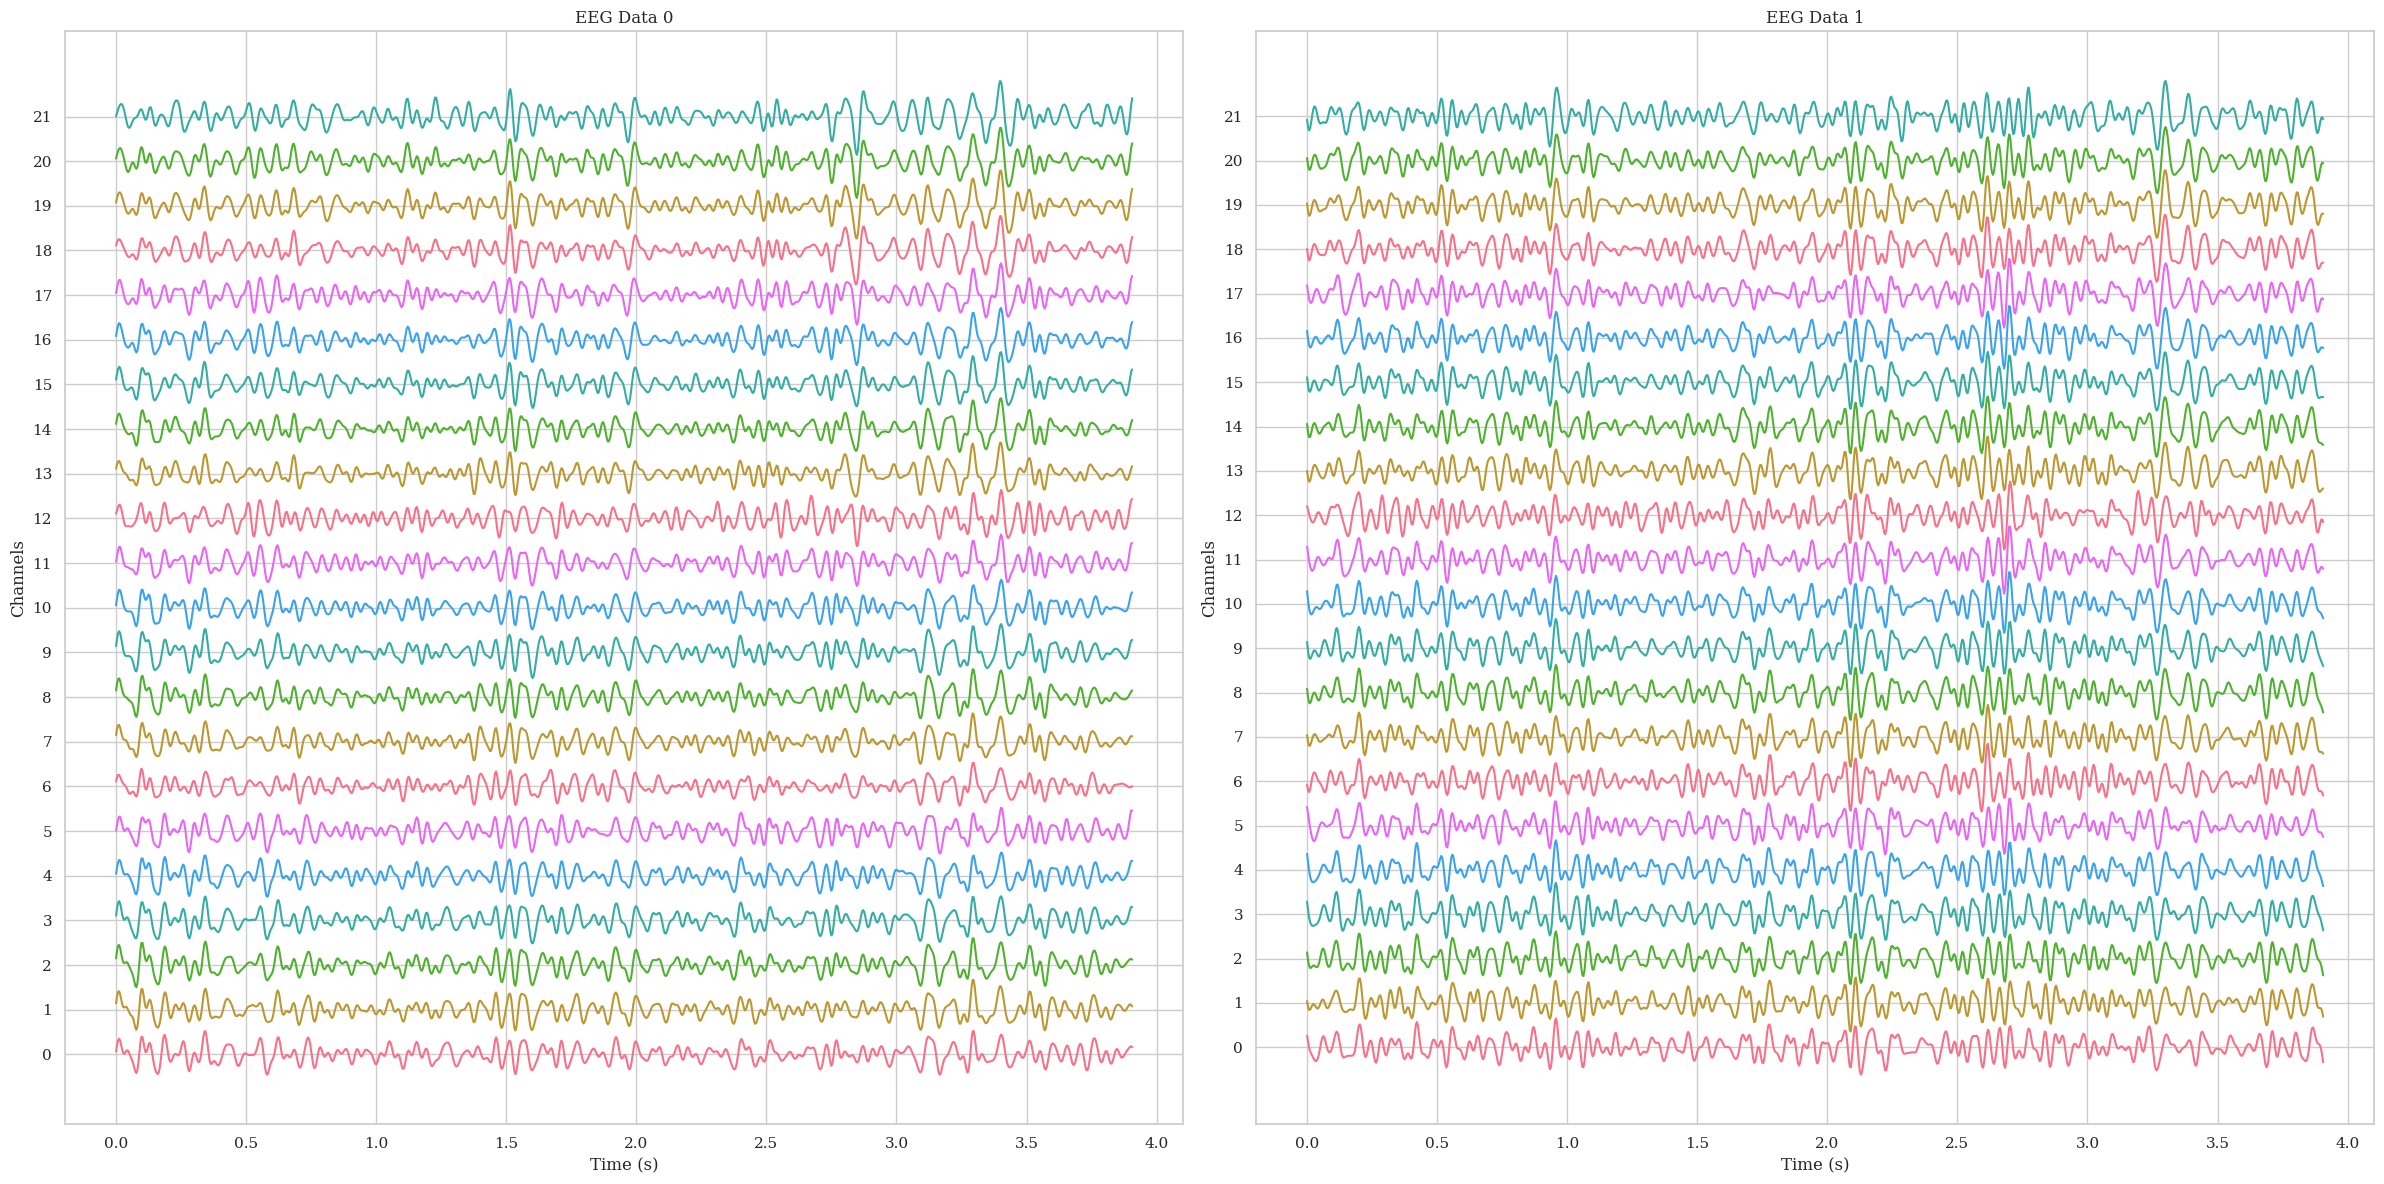

In [9]:
# Generate a random integer between a and b
class_name = -1

fig = plt.figure()
fig = plt.figure(figsize=(24,12),dpi=100)



for i in [0,1] : 
    while class_name != i :
        num = random.randint(0, len(X) )
        signal = X[num].copy()
        class_name = int_labels[num]
    
    # Define a figure and axis to plot
    ax = fig.add_subplot(1,2,i+1)
    
    # Number of channels
    num_channels = signal.shape[0]
    
    # Generate a time axis based on your DataFrame's index (assuming it's time in seconds)
    time = [i/256 for i in range(signal.shape[1]) ]
    
    # Offset to separate the channels on the y-axis
    offset = 25
    
    # Define initial offset for alignment
    initial_offset = 0
    
    # Plot each channel and set the y-ticks
    y_ticks = []
    channel_labels = []
    for i in range(num_channels):
        # Calculate the vertical offset
        vertical_position = initial_offset + i * offset
        ax.plot(time, signal[i] + vertical_position, label=str(i))
        y_ticks.append(vertical_position)
        channel_labels.append(str(i))
    
    # Set the y-ticks to the middle of each channel's data
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(channel_labels)
    
    # Set labels and title
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Channels')
    ax.set_title('EEG Data ' + str(class_name))
    
    # Hide the legend if you prefer the y-ticks as labels
    # ax.legend(loc='upper right')
    
    # Show the plot
plt.tight_layout()

plt.show()

### Let's train and test the model

In [10]:
from skorch.callbacks import LRScheduler
from braindecode import EEGClassifier

In [49]:
import torch
from braindecode.util import set_random_seeds
from braindecode.models import ShallowFBCSPNet

cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = "cuda" if cuda else "cpu"
if cuda:
    torch.backends.cudnn.benchmark = True
seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 2
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = 22
input_window_samples = 1001

model = ShallowFBCSPNet(
    n_channels,
    n_classes,
    n_times=input_window_samples,
    final_conv_length="auto",
)

# Display torchinfo table describing the model
print(model)

# Send model to GPU
if cuda:
    model.cuda()

Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1001]             [1, 2]                    --                        --
├─Ensure4d (ensuredims): 1-1             [1, 22, 1001]             [1, 22, 1001, 1]          --                        --
├─Rearrange (dimshuffle): 1-2            [1, 22, 1001, 1]          [1, 1, 1001, 22]          --                        --
├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1001, 22]          [1, 40, 977, 1]           36,240                    --
├─BatchNorm2d (bnorm): 1-4               [1, 40, 977, 1]           [1, 40, 977, 1]           80                        --
├─Expression (conv_nonlin_exp): 1-5      [1, 40, 977, 1]           [1, 40, 977, 1]           --                        --
├─AvgPool2d (pool): 1-6                  [1, 40, 977, 1]           [1, 40, 61, 1]            --                        [75, 1]
├─Express

In [56]:
model

ShallowFBCSPNet(
  (ensuredims): Ensure4d()
  (dimshuffle): Rearrange('batch C T 1 -> batch 1 T C')
  (conv_time_spat): CombinedConv(
    (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
    (conv_spat): Conv2d(40, 40, kernel_size=(1, 22), stride=(1, 1), bias=False)
  )
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin_exp): Expression(expression=square) 
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(15, 1), padding=0)
  (pool_nonlin_exp): Expression(expression=safe_log) 
  (drop): Dropout(p=0.5, inplace=False)
  (final_layer): Sequential(
    (conv_classifier): Conv2d(40, 2, kernel_size=(61, 1), stride=(1, 1))
    (logsoftmax): LogSoftmax(dim=1)
    (squeeze): Expression(expression=squeeze_final_output) 
  )
)

In [53]:
lr = 0.0625 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 20

clf = EEGClassifier(
    model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=None,
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy",
        ("lr_scheduler", LRScheduler("CosineAnnealingLR", T_max=n_epochs - 1)),
    ],
    device=device,
    classes=[0,1],
    max_epochs=n_epochs,
)

In [54]:
clf.fit(X, y=int_labels)

  epoch    train_accuracy    train_loss      lr     dur
-------  ----------------  ------------  ------  ------
      1            0.7986        0.6041  0.0006  0.1403
      2            0.7865        0.3994  0.0006  0.0968
      3            0.9045        0.3586  0.0006  0.0969
      4            0.9392        0.2832  0.0006  0.0971
      5            0.9462        0.2714  0.0006  0.0965
      6            0.9670        0.2038  0.0005  0.0921
      7            0.9757        0.2084  0.0005  0.0942
      8            0.9549        0.1511  0.0004  0.0913
      9            0.9809        0.1718  0.0004  0.0910
     10            0.9826        0.1914  0.0003  0.1064
     11            0.9878        0.1444  0.0003  0.0911
     12            0.9688        0.1482  0.0002  0.0918
     13            0.9757        0.1305  0.0002  0.0926
     14            0.9931        0.1245  0.0001  0.0951
     15            0.9948        0.1240  0.0001  0.0909
     16            0.9931        0.1265  0.0001 

<class 'braindecode.classifier.EEGClassifier'>[initialized](
  module_=============================================================================================================================================
  Layer (type (var_name):depth-idx)        Input Shape               Output Shape              Param #                   Kernel Shape
  ShallowFBCSPNet (ShallowFBCSPNet)        [1, 22, 1001]             [1, 2]                    --                        --
  ├─Ensure4d (ensuredims): 1-1             [1, 22, 1001]             [1, 22, 1001, 1]          --                        --
  ├─Rearrange (dimshuffle): 1-2            [1, 22, 1001, 1]          [1, 1, 1001, 22]          --                        --
  ├─CombinedConv (conv_time_spat): 1-3     [1, 1, 1001, 22]          [1, 40, 977, 1]           36,240                    --
  ├─BatchNorm2d (bnorm): 1-4               [1, 40, 977, 1]           [1, 40, 977, 1]           80                        --
  ├─Expression (conv_nonlin_exp): 

### Train and test the model using my usual code

In [11]:
from sklearn.model_selection import KFold

y = int_labels 
kf = KFold(n_splits=5)
fold = 0

train_val_dict = {}
for value in ['train' , 'val']:
    train_val_dict[value] = {}

for train_index, val_index   in kf.split(X, y):
    fold += 1
    X_train, y_train  = X[train_index], y[train_index]
    X_val, y_val =  X[val_index], y[val_index] 
 
    train_val_dict['train'][fold] = X_train, y_train
    train_val_dict['val'][fold]   = X_val, y_val
    
    total_len = len(X)
 
    val_percent = 100*(len(X_val) / total_len)
    train_percent = 100*(len(X_train) / total_len)
    
    
    print('fold ' + str(fold) ) 
    print( str(train_percent)[:3] + ' | '  + str(val_percent)[:3] + ' |' )


    
    # print('__________________________________________________________________________')


fold 1
79. | 20. |
fold 2
80. | 19. |
fold 3
80. | 19. |
fold 4
80. | 19. |
fold 5
80. | 19. |


In [12]:
# define the model 

n_classes = 2
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_channels = 22
input_window_samples = 1001

model = ShallowFBCSPNet(
    n_channels,
    n_classes,
    n_times=input_window_samples,
    final_conv_length="auto",
)

NameError: name 'ShallowFBCSPNet' is not defined

In [13]:
from braindecode.models import EEGConformer

In [14]:
model = EEGConformer(
    n_chans = 22,
    n_outputs = 2 ,
    n_times=input_window_samples )

/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/braindecode/models/base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [67]:
y_pred = model(X_train_batch)
y_pred

tensor([[-1.7002e+01,  0.0000e+00],
        [-1.5011e+01, -3.5763e-07],
        [-1.4792e+01, -3.5763e-07],
        [-1.3692e+01, -1.0729e-06],
        [-7.7299e+00, -4.3955e-04],
        [-1.1921e-07, -1.5818e+01],
        [-1.1921e-07, -1.6626e+01],
        [-1.1921e-07, -1.6047e+01],
        [-2.2411e-05, -1.0708e+01],
        [-1.3983e+01, -8.3446e-07],
        [-1.2436e+01, -3.9339e-06]], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [ ]:
# Convert LogSoftmax outputs to probabilities
probs = torch.exp(y_pred)

# Select the class with the highest probability
predicted_classes = torch.argmax(probs, dim=1)

In [71]:
len(X)

576

In [22]:
X_train_batch.shape

torch.Size([12, 22, 1001])

In [87]:
model = EEGConformer(
        n_chans = 22,
        n_outputs = 2 ,
        n_times=input_window_samples )
model

EEGConformer(
  (patch_embedding): _PatchEmbedding(
    (shallownet): Sequential(
      (0): Conv2d(1, 40, kernel_size=(1, 25), stride=(1, 1))
      (1): Conv2d(40, 40, kernel_size=(22, 1), stride=(1, 1))
      (2): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ELU(alpha=1.0)
      (4): AvgPool2d(kernel_size=(1, 75), stride=(1, 15), padding=0)
      (5): Dropout(p=0.5, inplace=False)
    )
    (projection): Sequential(
      (0): Conv2d(40, 40, kernel_size=(1, 1), stride=(1, 1))
      (1): Rearrange('b d_model 1 seq -> b seq d_model')
    )
  )
  (transformer): _TransformerEncoder(
    (0): _TransformerEncoderBlock(
      (0): _ResidualAdd(
        (fn): Sequential(
          (0): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
          (1): _MultiHeadAttention(
            (keys): Linear(in_features=40, out_features=40, bias=True)
            (queries): Linear(in_features=40, out_features=40, bias=True)
            (values): Linear(in

Commencing Training ...
1


/user/home/ko20929/.conda/envs/sktime_latest/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


<Figure size 640x480 with 0 Axes>

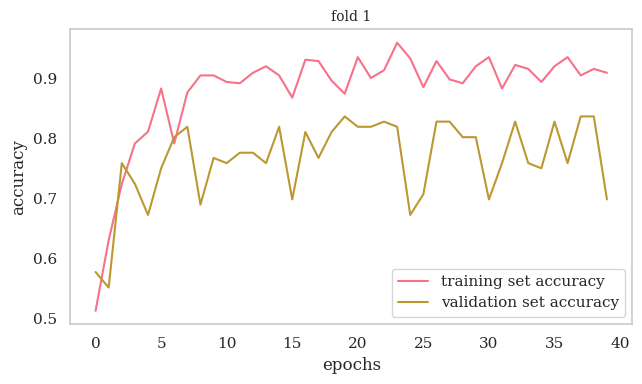

In [20]:
import time

start_time = time.time()

seeds = [2]
rows = len(seeds) # Make the figure the right size 

fig = plt.figure()
fig = plt.figure(figsize=(24,4*rows),dpi=100)

# k is for subplots within the overall figure 

k = 1
print('Commencing Training ...')
# for fold in [1,2,3,4]:
for fold in [1]:
    print(fold)
    X_train, y_train = train_val_dict['train'][fold]
    X_val, y_val = train_val_dict['val'][fold]  
    
    # Creating train and test data loaders
    train_data = [ (torch.from_numpy(input_slice).float(), val) for input_slice, val in zip(X_train, y_train) ] 
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
    
    val_data = [ (torch.from_numpy(input_slice).float() , val) for input_slice, val in zip(X_val, y_val) ] 
    val_loader = DataLoader(val_data , batch_size=64, shuffle=False)
    
    # for seed in [2,5,15,50]:
    
    for seed in seeds:
        
        #Define the model 
        model = EEGConformer(
                    n_chans = 22,
                    n_outputs = 2 ,
                    n_times=input_window_samples )
        
        # n_classes = 2
        # classes = list(range(n_classes))
        # # Extract number of chans and time steps from dataset
        # n_channels = 22
        # input_window_samples = 1001
        
        # model = ShallowFBCSPNet(
        #     n_channels,
        #     n_classes,
        #     n_times=input_window_samples,
        #     final_conv_length="auto",
        # )
                
        # set all seeds 
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # print(device) - to check that device is actually cuda
        
        
        model.to(device)
        
        criterion = torch.nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.001 )

        epochs = 40
        train_losses = []
        val_losses = []
        test_losses = []
        
        train_correct = []
        val_correct = []
        test_correct = []
        
        for i in range(epochs):
            
            trn_corr = 0
            val_corr = 0
            tst_corr = 0
             
            
            trn_loss = 0
            val_loss = 0
            tst_loss = 0
            
            model.train()
            # Run the training batches
            for b, (X_train_batch, y_train_batch) in enumerate(train_loader):
                b+=1
        
                #Move train data to the GPU
                X_train_batch = X_train_batch.to(device)
                y_train_batch = y_train_batch.to(device)
                
                # Apply the model
                y_pred = model(X_train_batch)  # we don't flatten X-train here
                loss = criterion(y_pred, y_train_batch)
         
                # Tally the number of correct predictions
                predicted = torch.argmax(torch.exp(y_pred.detach()) ,  dim = 1 ) 

                predicted = predicted.reshape(y_train_batch.shape)
                
                batch_corr = (predicted == y_train_batch).sum()
                trn_corr += batch_corr
                trn_loss += loss
                
                # Update parameters
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
            train_losses.append(trn_loss)
            train_correct.append(trn_corr)
        
            # Run the validation batches
            # Some of the variables in this loop have the same name as the variables in the above loop... be aware of that plz!
            model.eval()
            with torch.no_grad():
                for b, (X_val_batch, y_val_batch) in enumerate(val_loader):
                    b+=1
                    
                    #Move train data to the GPU
                    X_val_batch = X_val_batch.to(device)
                    y_val_batch = y_val_batch.to(device)
        
                    # Apply the model
                    y_val = model(X_val_batch)
        
                    # Tally the number of correct predictions
                    predicted = torch.argmax(torch.exp(y_val.detach()),  dim = 1 ) 
                    predicted = predicted.reshape(y_val_batch.shape)
                    
                    batch_corr = (predicted == y_val_batch).sum()
                    val_corr += batch_corr
        
                    loss = criterion(y_val, y_val_batch)
                    val_loss += loss 
                   
            val_losses.append(val_loss)
            val_correct.append(val_corr)
        
            
           
        
        # Plot the outcome from the loop
        
        ax = fig.add_subplot(rows,4,k)
        k+=1
        plt.title('fold ' + str(fold), fontsize = 10)
        plt.plot([(val.cpu() / len(X_train) ) for val in train_correct], label='training set accuracy')
        plt.plot([(val.cpu()/len(X_val) ) for val in val_correct], label='validation set accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epochs') 
        plt.grid()
    
    
    plt.tight_layout()


plt.legend()   
plt.tight_layout()
    

EEG Conformer Model <br> 

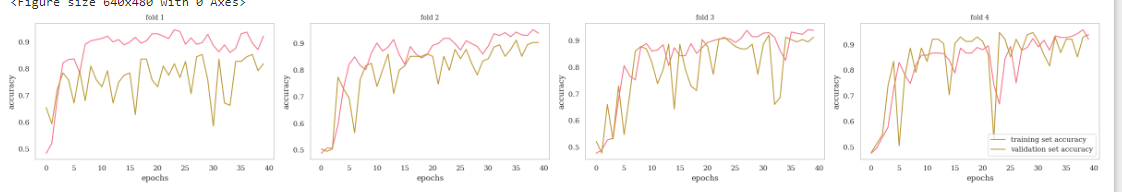

These results are from the ShallowFBCSPNet model - going to run EEG Conformer above
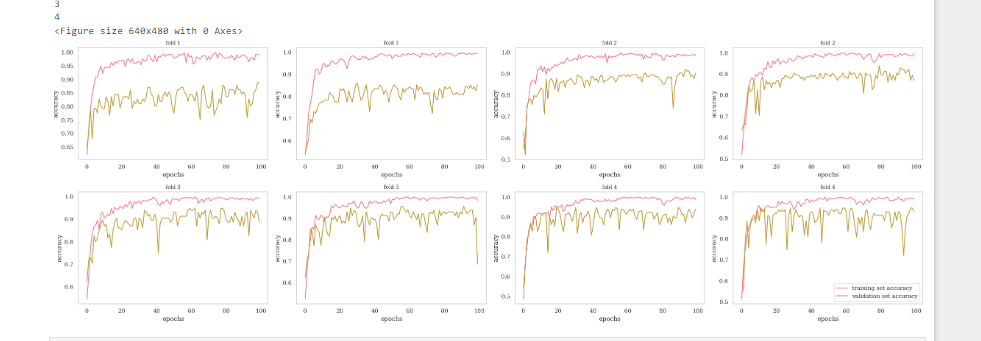